# Mr.HelpMate AI

Prepared by Mythili Kandula

The goal of the project is to build a robust generative search system capable of effectively and accurately answering questions from a group policy document “Principal-Sample-Life-Insurance-Policy.pdf”

In [1]:
# Install the following packages incase they're not loaded already
!pip install pdfplumber
!pip install chromadb
!pip install tiktoken
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.2/599.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import chromadb
import openai

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/upgrad/HelpMate')
!ls

ChromaDB_Data			     HelpMate_AI_Assignment_query3.ipynb
data				     HelpMate_AI_Live_Session.ipynb
HelpMate_AI_Assignment.ipynb	     HelpMate_AI_Live_Session_updated.ipynb
HelpMate_AI_Assignment_query2.ipynb  uber_2021.pdf


In [5]:
# Set the API key
filepath = "/content/drive/MyDrive/upgrad/GenAI_Course_Master/"

with open(filepath + "OpenAI_API_Key_HH.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

## Quick Recap of RAG

Quick Recap of a RAG system

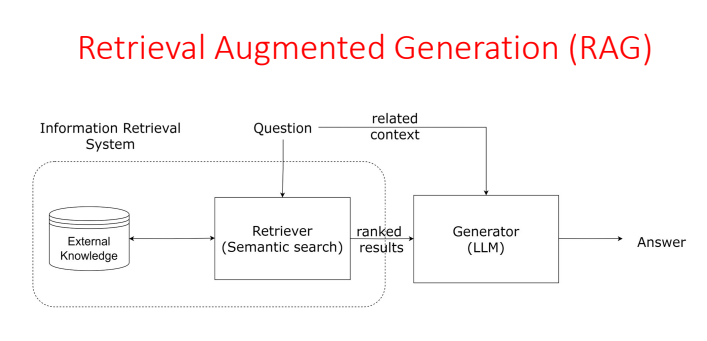

In [6]:
## Issues with normal LLMs
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":"What is the premium rate for the member insured for group policy in 2024?"},
          ]

In [7]:
## New method (as older completion and chatcompletion endpoints have been deprecated)
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'I would need more information in order to provide you with the premium rate for a group policy member insured in 2024. Factors such as the type of insurance, coverage amount, age, health status, and any additional features could all impact the premium rate. I recommend reaching out to the insurance provider or HR department that manages the group policy for the most accurate and up-to-date information.'

As you see the LLMs may not have access to your internal data, and therefore, they won't be able to **retrieve** information beyond the data that they have been trained on

Here's the relevant snippet from Rhode Island John Doe
 Group Life insurance policy document Principal-Sample-Life-Insurance-Policy.pdf page 20

The premium rate(s) for each Member insured for Life Insurance will be:
a. Member Life Insurance
$0.210 for each $1,000 of insurance in force.
b. Member Accidental Death and Dismemberment Insurance
$0.025 for each $1,000 of Member Life Insurance in force.
c. Dependent Life Insurance
$1.46 for each Member insured for Dependent Life Insurance.

In [8]:
retrieved = "Member Life Insurance $0.210 for each $1,000 of insurance in force"

In [9]:
messages = [
    {"role":"system", "content":"You are an AI assistant to user."},
    {"role":"user", "content":f"""What is the premium rate for the member insured?. Use the information presented in '{retrieved}' """},
          ]

In [10]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

'To determine the premium rate for the member insured, we can calculate it based on the information provided. \n\nGiven that the premium rate is $0.210 for each $1,000 of insurance in force, we can calculate the premium rate per $1 of insurance by dividing $0.210 by 1,000:\n\n$0.210 / 1,000 = $0.00021 per $1 of insurance\n\nTherefore, the premium rate for the member insured is $0.00021 per $1 of insurance.'

So what we did above was,
- We **retrieved** the information from an external source,
- **Augmented** our query with the relevant information prompt,
- and finally we **generated** the relevant response

This above process is RAG in a nutshell!

## Starter Code explanation

### Data Processing

Quite crucial, hence suggested to use good parsers that can load the data from your documents effectively.


In [11]:
pdf_path = "/content/drive/MyDrive/upgrad/HelpMate/data/"

In [12]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [13]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [14]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [15]:
grouppolicy_pdfs_data = pd.concat(data, ignore_index=True)

In [16]:
grouppolicy_pdfs_data.head(5)

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


In [17]:
len(grouppolicy_pdfs_data)

64

In [18]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

grouppolicy_pdfs_data['Text_Length'] = grouppolicy_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [19]:
grouppolicy_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [20]:
# Retain only the rows with a text length of at least 10

grouppolicy_pdfs_data = grouppolicy_pdfs_data.loc[grouppolicy_pdfs_data['Text_Length'] >= 10]
grouppolicy_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


In [21]:
grouppolicy_pdfs_data['Metadata'] = grouppolicy_pdfs_data.apply(lambda x: {'filing_name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [22]:
grouppolicy_pdfs_data.head(5)

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'filing_name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'filing_name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'filing_name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'filing_name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'filing_name': 'Principal-Sample-Life-Insuran...


## Generate and Store Embeddings using OpenAI and ChromaDB
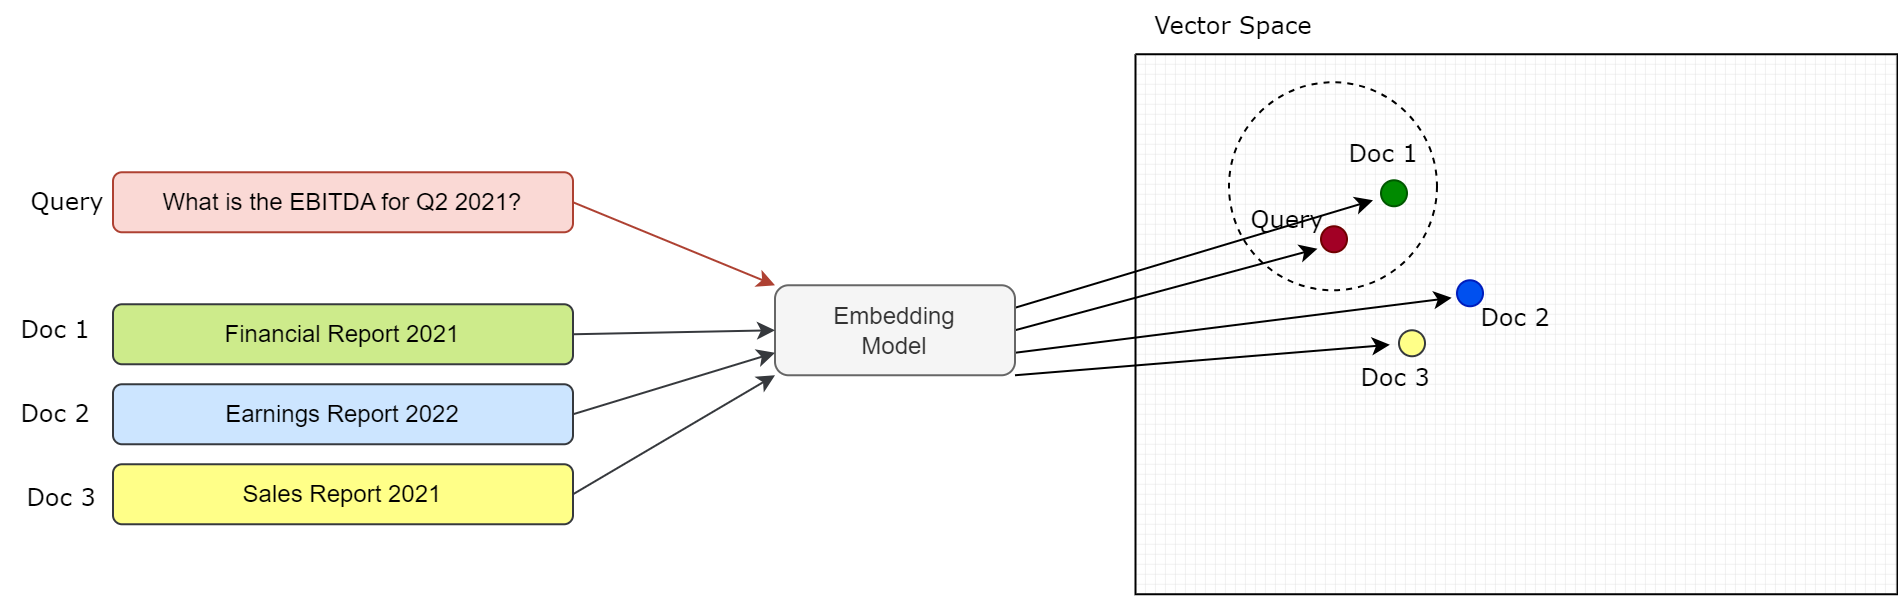

In [23]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [24]:
# Define the path where chroma collections will be stored

chroma_data_path = "/content/drive/MyDrive/upgrad/HelpMate/data/ChromaDB_Data"

In [25]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [26]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [27]:
## Create an empty collection
grouppolicydata_collection = client.get_or_create_collection(name='RAG_on_RhodeIslandGroupPolicy', embedding_function=embedding_function)

In [28]:
documents_list = grouppolicy_pdfs_data["Page_Text"].tolist()
metadata_list = grouppolicy_pdfs_data['Metadata'].tolist()

In [29]:
metadata_list

[{'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 1'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 3'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 5'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 6'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 7'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 8'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 9'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 10'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 11'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 12'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.': 'Page 13'},
 {'filing_name': 'Principal-Sample-Life-Insurance-Policy',
  'Page_No.':

In [112]:
?grouppolicydata_collection.add

In [30]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

grouppolicydata_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [31]:
grouppolicydata_collection

Collection(id=a97a971e-2d6c-4921-bd08-f6a37d9b85a0, name=RAG_on_RhodeIslandGroupPolicy)

In [32]:
grouppolicydata_collection.peek(2)

{'ids': ['0', '1'],
 'embeddings': [[-0.022469419986009598,
   0.01871146820485592,
   -0.02729734405875206,
   -0.031290166079998016,
   -0.0036731369327753782,
   0.027923669666051865,
   0.0008538575493730605,
   0.023656828328967094,
   -0.016571523621678352,
   0.004253792576491833,
   -0.005251998547464609,
   0.004058065824210644,
   -0.006273039150983095,
   0.023252326995134354,
   -0.011299951933324337,
   0.030977005138993263,
   0.002877181861549616,
   -0.024726800620555878,
   0.03055945597589016,
   0.007920404896140099,
   0.006413309834897518,
   0.01886804960668087,
   0.00953188817948103,
   0.012689611874520779,
   -0.012356876395642757,
   -0.009440548717975616,
   0.017889415845274925,
   -0.021686512976884842,
   0.023526344448328018,
   0.0030223457142710686,
   0.013283316045999527,
   -0.0145490150898695,
   -0.03361279144883156,
   -0.041180890053510666,
   -0.00845539104193449,
   0.013531235978007317,
   -0.0026716687716543674,
   -0.0038688634522259235,
  

In [33]:
# Let's take a look at the first few entries in the collection

grouppolicydata_collection.get(
   # ids = ['0','1','2'],
   # include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0',
  '1',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '2',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '3',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '4',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '5',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '6',
  '60',
  '61',
  '62',
  '63',
  '7',
  '8',
  '9'],
 'embeddings': None,
 'metadatas': [{'Page_No.': 'Page 1',
   'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
  {'Page_No.': 'Page 2',
   'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
  {'Page_No.': 'Page 11',
   'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
  {'Page_No.': 'Page 12',
   'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
  {'Page_No.': 'Page 13',
   'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
  {'Page_No.': 'Page 14

In [34]:
cache_collection = client.get_or_create_collection(name='grouppolicy2_Cache', embedding_function=embedding_function)

In [35]:
cache_collection.peek()

{'ids': ['What is the eligibility criteria for dependents?',
  'What is the premium rate for the member insured?'],
 'embeddings': [[0.014582330361008644,
   0.004188541788607836,
   0.011553900316357613,
   -0.029461434110999107,
   -0.03947076573967934,
   0.04049598053097725,
   -0.01887204498052597,
   -0.006481785327196121,
   -0.03240218013525009,
   -0.015000510029494762,
   0.023350615054368973,
   0.008545704185962677,
   0.0032189718913286924,
   0.00446845218539238,
   -0.009806987829506397,
   0.010063291527330875,
   0.020167052745819092,
   -0.032213326543569565,
   0.03679981082677841,
   -0.024079056456685066,
   -0.023337123915553093,
   -0.008768283762037754,
   -0.017185837030410767,
   0.0021448570769280195,
   -0.008464766666293144,
   0.0048697697930037975,
   -0.0018700051587074995,
   -0.03245614096522331,
   0.015769420191645622,
   -0.021475549787282944,
   0.03083737939596176,
   -0.0075474688783288,
   -0.029947061091661453,
   -0.026507196947932243,
   0.00

## Semantic Search with Cache

We have created 2 collections
- grouppolicydata_collection (embeddings are already present)
- cache_collection (an empty collection at the beginning)

Our strategy is to first check the cache_collection and see if can answer the query or not.

In case it doesn't the query then passes to the grouppolicydata_collection, and the query results get appended to cache_collection (embeddings, metadata, etc)

Semantic Search Pipeline

In [36]:
# Read the user query
query = input()

What is the premium rate for the member insured?


In [37]:
query

'What is the premium rate for the member insured?'

In [38]:
## Quickly checking the results of the query
results = grouppolicydata_collection.query(
      query_texts=query,
      n_results=10
      )

In [39]:
results

{'ids': [['20', '21', '19', '16', '45', '52', '51', '23', '58', '56']],
 'distances': [[0.30323126912117004,
   0.30561402440071106,
   0.3087538778781891,
   0.34121179580688477,
   0.3511160612106323,
   0.3593869209289551,
   0.3628302216529846,
   0.37445056438446045,
   0.3749206066131592,
   0.3751755356788635]],
 'metadatas': [[{'Page_No.': 'Page 21',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 22',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 20',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 17',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 46',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 53',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 52',
    'filing_name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 24',
    'filing_name

In [40]:
for key, val in results.items():
  print(key)

ids
distances
metadatas
embeddings
documents
uris
data
included


In [41]:
for key, val in results.items():
  print(val)

[['20', '21', '19', '16', '45', '52', '51', '23', '58', '56']]
[[0.30323126912117004, 0.30561402440071106, 0.3087538778781891, 0.34121179580688477, 0.3511160612106323, 0.3593869209289551, 0.3628302216529846, 0.37445056438446045, 0.3749206066131592, 0.3751755356788635]]
[[{'Page_No.': 'Page 21', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 22', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 20', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 17', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 46', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 53', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 52', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 24', 'filing_name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 59', 'filing_name': 'Principal-Sample-Life-Insurance-

Building the cache

In [42]:
# Searh the Cache collection first
# Query the collection against the user query and return the top result

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [43]:
cache_results

{'ids': [['What is the premium rate for the member insured?']],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.30323126912117004',
    'distances1': '0.30561402440071106',
    'distances2': '0.3087538778781891',
    'distances3': '0.34121179580688477',
    'distances4': '0.3511160612106323',
    'distances5': '0.3593869209289551',
    'distances6': '0.37445056438446045',
    'distances7': '0.3749206066131592',
    'distances8': '0.38009247183799744',
    'documents0': "b . on any date the definition of Member or Dependent is changed; and c. on any date the Policyholder's business, as specified on the Policyholder application, is changed; and d. on any date that a schedule of insurance or class of insured Members is changed; and e. on any premium due date, if the Policyholder has been receiving a multiple policy discount rate and the Policyholder drops below the minimum number of coverages to receive such discount rate; and f. on any date the premium contribution required of M

In [44]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = grouppolicydata_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []
      #total_index = len(results['distances'])
      #print(total_index)
      for key, val in results.items():
        if key not in ['embeddings', 'uris','data']:
          for i in range(9):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Found in cache!


In [45]:
results_df

,IDs,Documents,Distances,Metadatas
0,20,b . on any date the definition of Member or De...,0.30323126912117004,"{'Page_No.': 'Page 21', 'filing_name': 'Princi..."
1,21,The number of Members insured for Dependent Li...,0.30561402440071106,"{'Page_No.': 'Page 22', 'filing_name': 'Princi..."
2,19,Section B - Premiums Article 1 - Payment Respo...,0.3087538778781891,"{'Page_No.': 'Page 20', 'filing_name': 'Princi..."
3,16,a. be actively engaged in business for profit ...,0.34121179580688477,"{'Page_No.': 'Page 17', 'filing_name': 'Princi..."
4,45,PART IV - BENEFITS Section A - Member Life Ins...,0.3511160612106323,"{'Page_No.': 'Page 46', 'filing_name': 'Princi..."
5,52,Section B - Member Accidental Death and Dismem...,0.3593869209289551,"{'Page_No.': 'Page 53', 'filing_name': 'Princi..."
6,23,T he Principal may terminate the Policyholder'...,0.37445056438446045,"{'Page_No.': 'Page 24', 'filing_name': 'Princi..."
7,58,Section C - Dependent Life Insurance Article 1...,0.3749206066131592,"{'Page_No.': 'Page 59', 'filing_name': 'Princi..."
8,17,c . a copy of the form which contains the stat...,0.38009247183799744,"{'Page_No.': 'Page 18', 'filing_name': 'Princi..."


In [46]:
## Checking if the cache also contains the results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [47]:
cache_results

{'ids': [['What is the premium rate for the member insured?']],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.30323126912117004',
    'distances1': '0.30561402440071106',
    'distances2': '0.3087538778781891',
    'distances3': '0.34121179580688477',
    'distances4': '0.3511160612106323',
    'distances5': '0.3593869209289551',
    'distances6': '0.37445056438446045',
    'distances7': '0.3749206066131592',
    'distances8': '0.38009247183799744',
    'documents0': "b . on any date the definition of Member or Dependent is changed; and c. on any date the Policyholder's business, as specified on the Policyholder application, is changed; and d. on any date that a schedule of insurance or class of insured Members is changed; and e. on any premium due date, if the Policyholder has been receiving a multiple policy discount rate and the Policyholder drops below the minimum number of coverages to receive such discount rate; and f. on any date the premium contribution required of M

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

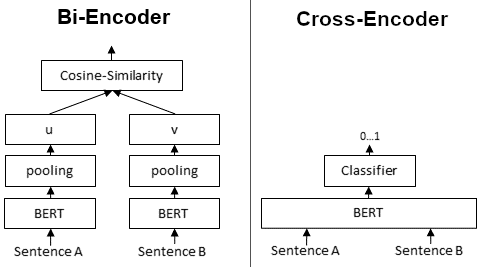

<br>

In [48]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.7 MB/s eta 0:00:00


In [49]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [50]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
# Test the cross encoder model

scores = cross_encoder.predict([['What is the premium rate for the member insured?', 'The premium rate(s) for each Member insured for Life Insurance will be: a. Member Life Insurance $0.210 for each $1,000 of insurance in force.'],
                                ['What is the premium rate for the member insured?', 'The reinstated coverage will be on the same basis as that being provided on the date coverage is reinstated.']])

In [135]:
scores

array([  9.1929865, -11.326315 ], dtype=float32)

In [52]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [54]:
 #Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [55]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,20,b . on any date the definition of Member or De...,0.30323126912117004,"{'Page_No.': 'Page 21', 'filing_name': 'Princi...",1.848200
1,21,The number of Members insured for Dependent Li...,0.30561402440071106,"{'Page_No.': 'Page 22', 'filing_name': 'Princi...",2.263153
2,19,Section B - Premiums Article 1 - Payment Respo...,0.3087538778781891,"{'Page_No.': 'Page 20', 'filing_name': 'Princi...",1.183004
3,16,a. be actively engaged in business for profit ...,0.34121179580688477,"{'Page_No.': 'Page 17', 'filing_name': 'Princi...",1.005047
4,45,PART IV - BENEFITS Section A - Member Life Ins...,0.3511160612106323,"{'Page_No.': 'Page 46', 'filing_name': 'Princi...",-1.242583
5,52,Section B - Member Accidental Death and Dismem...,0.3593869209289551,"{'Page_No.': 'Page 53', 'filing_name': 'Princi...",-2.386362
6,23,T he Principal may terminate the Policyholder'...,0.37445056438446045,"{'Page_No.': 'Page 24', 'filing_name': 'Princi...",-7.833142
7,58,Section C - Dependent Life Insurance Article 1...,0.3749206066131592,"{'Page_No.': 'Page 59', 'filing_name': 'Princi...",-3.499780
8,17,c . a copy of the form which contains the stat...,0.38009247183799744,"{'Page_No.': 'Page 18', 'filing_name': 'Princi...",-5.278223


In [56]:
# Return the top 3 results from semantic search
top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,20,b . on any date the definition of Member or De...,0.30323126912117004,"{'Page_No.': 'Page 21', 'filing_name': 'Princi...",1.848200
1,21,The number of Members insured for Dependent Li...,0.30561402440071106,"{'Page_No.': 'Page 22', 'filing_name': 'Princi...",2.263153
2,19,Section B - Premiums Article 1 - Payment Respo...,0.3087538778781891,"{'Page_No.': 'Page 20', 'filing_name': 'Princi...",1.183004


In [57]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [58]:
top_3_RAG

,Documents,Metadatas
1,The number of Members insured for Dependent Li...,"{'Page_No.': 'Page 22', 'filing_name': 'Princi..."
0,b . on any date the definition of Member or De...,"{'Page_No.': 'Page 21', 'filing_name': 'Princi..."
2,Section B - Premiums Article 1 - Payment Respo...,"{'Page_No.': 'Page 20', 'filing_name': 'Princi..."


In [59]:
top_3_RAG['Documents'].iloc[0]

"The number of Members insured for Dependent Life Insurance will be multiplied by the premium rate then in effect. To ensure accurate premium calculations, the Policyholder is responsible for reporting to The Principal, the following information during the stated time periods: a. Members who are eligible to become insured are to be reported during the month prior to or during the month that coverage becomes effective. b. Members whose coverage has terminated are to be reported within a month of the date coverage terminated. c. Changes in Member insurance class are to be reported within a month of the date that the change in insurance class took place. If a Member is added or a present Member's insurance is increased or terminated on other than the first of an Insurance Month, premium for that Member will be adjusted and applied as if the change were to take place on the first of the next following Insurance Month. Article 5 - Contributions from Members Members are not required to contr

## Build the RAG system

In [61]:
retrieved = top_3_RAG['Documents'].iloc[0]

In [62]:
messages = [
    {"role":"system", "content":"You are a HelpMate AI assistant to user."},
    {"role":"user", "content":f"""{query}. You are provided the group policy in'{retrieved}'
                                  Follow the guidelines below when performing the task.
                                  1. Try to provide relevant/accurate numbers if available.
                                  2. Choose information that is relevant only.
                                  3. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the cited document.
                                  4. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                  The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                  """},
          ]

In [63]:
response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages)
response.choices[0].message.content

"The premium rate for the member insured is calculated by multiplying the number of members insured for Dependent Life Insurance by the premium rate then in effect. Members are not required to contribute to the premium for their own insurance under this Group Policy, but they are required to contribute a part of the premium for their Dependent's insurance.\n\nQuery: What is the premium rate for the member insured?\n\nResponse: The premium rate for the member insured is calculated based on the number of members insured for Dependent Life Insurance multiplied by the premium rate in effect.\n\nCitation: \nSource: The group policy in 'The number of Members insured for Dependent Life Insurance will be multiplied by the premium rate then in effect.'\nReference: PART II - POLICY ADMINISTRATION GC 6004 Section B - Premiums, Page 3"

Future Improvements

- The above prompt is a very simplistic one. Build a robust prompt template that can give you the search results, along with citations (Page No, metadata, etc)

- Test out the prompt results thoroughly,
- Modularize the different parts from semantic search section onwards. There can be better and more systematic pipelines.